In [701]:
import math
import numpy as np
import scipy
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
from scipy.stats import linregress
from scipy.fft import fft2, fftfreq
from scipy.io import savemat
from tqdm import tqdm

In [702]:
e = 8.5424546e-2
c = 1
m = 510.99906 # m_e
E = np.array([0, 0, 0]) # 0 Tesla
B = np.array([692.5, 0, 0]) # 1 Tesla
t_span = (0, 1519267) # 1 ns
p0 = np.array([0.577, 0.577, 0.577])*m # c/2*m_e
r0 = np.array([0, 0, 0])
rtol = 1e-5
p_atol = 1e-2
r_atol = 1
atol = np.array([p_atol, p_atol, p_atol, r_atol, r_atol, r_atol])
t_eval = np.linspace(*t_span, 10000)

In [720]:
def gamma(v):
    v2 = np.dot(v, v)
    if v2 > c**2:
        return 100
    return 1 / math.sqrt(1 - v2/c**2)
def lorentz(v):
    return e * (E + np.cross(v, B) / c)
def g0(v, l, gv):
    return v * gv**2 / m**2 / c**6 * np.dot(v, v) * [np.dot(l, l) - e**2 * np.dot(v, E)**2]
def fun(t, y):
    p, r = np.split(y, 2)
    v = p / m
    gv = gamma(v)
    l = lorentz(v)
    g = g0(v, l, gv)
    dpdt = l - 2/3 * e**2 / c * g
    drdt = v / gv
    return np.concatenate([dpdt, drdt])
def plot3D(ax, u, c, prefix, suffix):
    x, y, z = u
    sc = ax.scatter(x, y, z, c=c, cmap="hot", marker=".", s=1)
    plt.colorbar(sc, ax=ax, location="bottom", shrink=0.5, pad=0.01, label="t (s)")
    ax.set_xlabel(prefix + "x" + suffix)
    ax.set_ylabel(prefix + "y" + suffix)
    ax.set_zlabel(prefix + "z" + suffix)
    return ax
def run(fun, t, y, progress):
    progress.n = t
    progress.update(0)
    return fun(t, y)

In [721]:
np.divide(fun(0, np.concatenate([np.array([0.5, 0.5, 0.5])*m, r0]))[:3], p0)

array([-1.65845679e-07,  1.00317299e-01, -1.00317630e-01])

In [722]:
%%time
y0 = np.concatenate([p0, r0])
with tqdm(total=t_span[1], position=t_span[0]) as progress:
    sol = solve_ivp(lambda t, y: run(fun, t, y, progress), t_span, y0, method="RK45", t_eval=t_eval, dense_output=True, rtol=rtol, atol=atol)

100%|███████████████████████████████████████████████████████████████████| 1519267.0/1519267 [02:19<00:00, 10924.84it/s]

Wall time: 2min 19s


In [723]:
t_sol = sol.t
y_sol = sol.y
p_sol, r_sol = np.split(y_sol, 2)

In [724]:
t = 6.5821220e-16 * t_sol # in s
p = p_sol * 5.3442883e-28 # in kg * m/s
v = p_sol / m * 2.99792458e8 # in m/s
r = r_sol * 1.9732705e-7 # in m
r_corr_sol = r_sol - np.tile(np.mean(r_sol, axis=1), (r_sol.shape[1],1)).T
r_corr = r_corr_sol * 1.9732705e-7 # in m
v_corr = v - np.tile(np.mean(v, axis=1), (v.shape[1],1)).T
omega = np.cross(r_corr, v_corr, axis=0)/np.linalg.norm(r_corr[1:])**2

<Axes3DSubplot:xlabel='r_x (m)', ylabel='r_y (m)'>

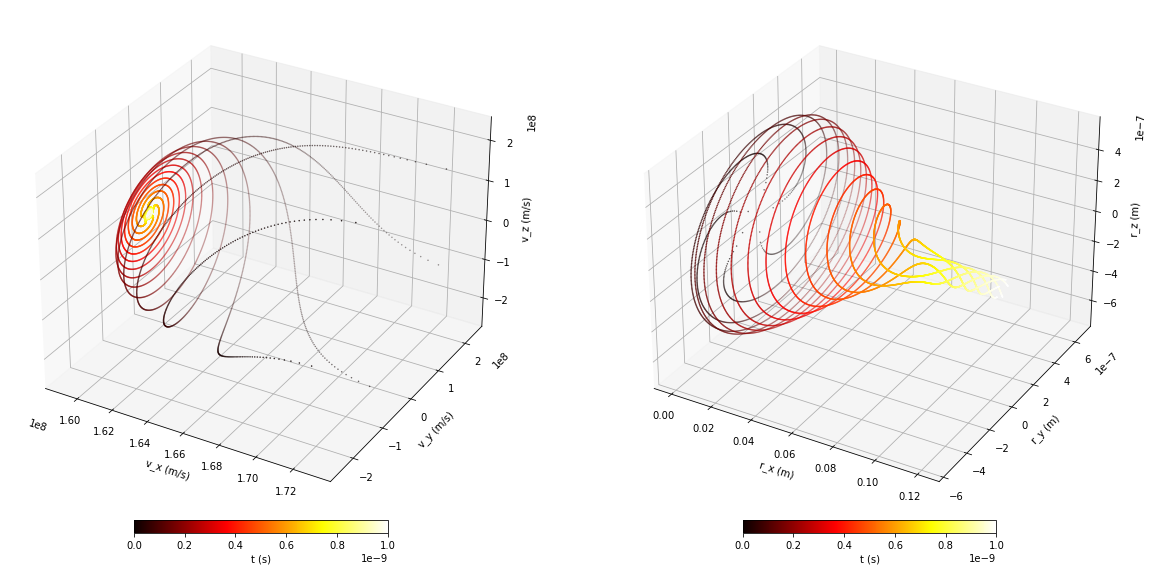

In [725]:
fig, axs = plt.subplots(1, 2, figsize=(20, 12), subplot_kw=dict(projection="3d"))
plot3D(axs[0], v, t, "v_", " (m/s)")
plot3D(axs[1], r, t, "r_", " (m)")

Text(0.5, 0, 't (s)')

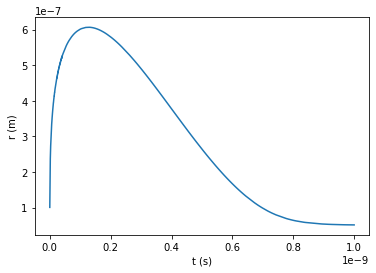

In [726]:
plt.plot(t, np.linalg.norm(r_corr[1:], axis=0))
plt.ylabel("r (m)")
plt.xlabel("t (s)")

Text(0.5, 0, 't (s)')

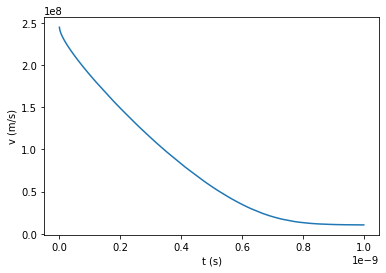

In [727]:
plt.plot(t, np.linalg.norm(v[1:], axis=0))
plt.ylabel("v (m/s)")
plt.xlabel("t (s)")

Text(0.5, 0, 't (s)')

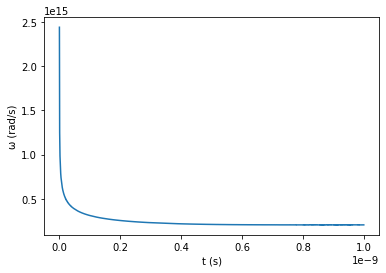

In [728]:
plt.plot(t, np.linalg.norm(v_corr[1:], axis=0)/np.linalg.norm(r_corr[1:], axis=0))
plt.ylabel("ω (rad/s)")
plt.xlabel("t (s)")

Text(0.5, 0, 't (s)')

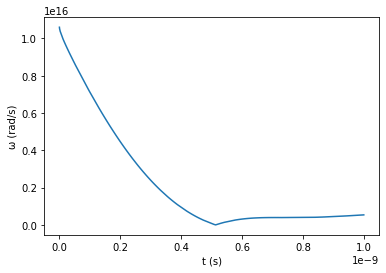

In [729]:
plt.plot(t, np.linalg.norm(omega, axis=0))
plt.ylabel("ω (rad/s)")
plt.xlabel("t (s)")

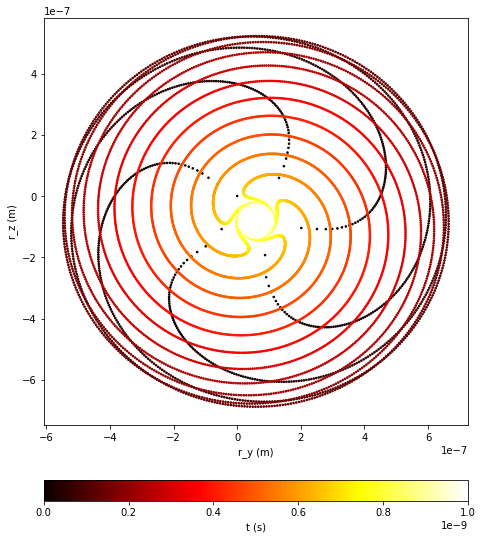

In [730]:
plt.figure(figsize=(7.6,10))
plt.scatter(*r[1:], marker=".", c=t, cmap="hot", s=10)
plt.xlabel("r_y (m)")
plt.ylabel("r_z (m)")
plt.colorbar(location="bottom", pad=0.1, label="t (s)")

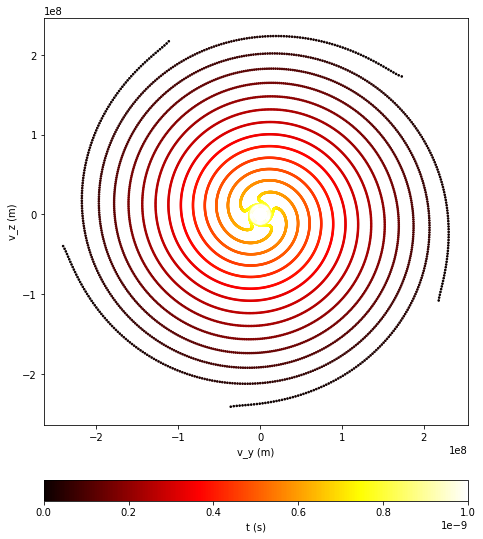

In [731]:
plt.figure(figsize=(7.6,10))
plt.scatter(*v[1:], marker=".", c=t, cmap="hot", s=10)
plt.xlabel("v_y (m)")
plt.ylabel("v_z (m)")
plt.colorbar(location="bottom", pad=0.1, label="t (s)")